# Árvores II - Tarefa 3

### 1. Carregar as bases

Vamos utilizar nesta tarefa as bases de reconhecimento de atividade humana através do celular. Carregue novamente as bases salvas na tarefa I.

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

In [5]:
# Carregar as features
features = pd.read_csv("features.txt", header=None, delim_whitespace=True, names=["index", "feature"])
features_list = features["feature"].tolist()

# Resolver duplicidade nos nomes das features
unique_features = pd.Series(features_list).duplicated(keep=False)
features_list = [f"{name}_{i}" if is_dup else name for i, (name, is_dup) in enumerate(zip(features_list, unique_features))]

# Carregar as bases de treino
X_train = pd.read_csv("X_train.txt", header=None, delim_whitespace=True, names=features_list)
y_train = pd.read_csv("y_train.txt", header=None, names=["activity"])
subject_train = pd.read_csv("subject_train.txt", header=None, names=["subject"])

# Carregar as bases de teste
X_test = pd.read_csv("X_test.txt", header=None, delim_whitespace=True, names=features_list)
y_test = pd.read_csv("y_test.txt", header=None, names=["activity"])
subject_test = pd.read_csv("subject_test.txt", header=None, names=["subject"])

# Verificar os dados carregados
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

<ipython-input-5-41ad172c99cb>:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  features = pd.read_csv("features.txt", header=None, delim_whitespace=True, names=["index", "feature"])
<ipython-input-5-41ad172c99cb>:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_train = pd.read_csv("X_train.txt", header=None, delim_whitespace=True, names=features_list)
<ipython-input-5-41ad172c99cb>:15: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  X_test = pd.read_csv("X_test.txt", header=None, delim_whitespace=True, names=features_list)


X_train shape: (7352, 561)
y_train shape: (7352, 1)
X_test shape: (2947, 561)
y_test shape: (2947, 1)


### 2. Calcule os ```ccp_alphas```.

Vamos seguir uma lógica bem em linha com o que já estamso acostumados, com as seguintes orientações:

- Utilizar treinamento e teste conforme já vieram definidos originalmente
- Por pragmatismo, utilizar ```min_samples_leaf=20```
- Utilize as mesmas "3 melhores variáveis" identificadas no exercício anterior.

In [6]:
%%time

# Selecionar as 3 melhores variáveis identificadas anteriormente
top_3_features = ["tBodyAcc-mean()-X", "tBodyAcc-mean()-Y", "tBodyAcc-mean()-Z"]

# Criar uma árvore de decisão com min_samples_leaf=20
tree = DecisionTreeClassifier(random_state=42, min_samples_leaf=20)

# Ajustar a árvore com as variáveis selecionadas e as bases originais
tree.fit(X_train[top_3_features], y_train)

# Calcular os ccp_alphas e os valores correspondentes às árvores
path = tree.cost_complexity_pruning_path(X_train[top_3_features], y_train)
ccp_alphas = path.ccp_alphas

# Filtrar valores positivos e únicos
ccp_alphas = sorted(set(alpha for alpha in ccp_alphas if alpha > 0))

# Exibir os resultados
print("CCP Alphas únicos e positivos:")
print(ccp_alphas)

CCP Alphas únicos e positivos:
[6.966745401948242e-06, 1.1276657087321029e-05, 2.0255406544851008e-05, 2.7203482045701916e-05, 2.849888595264009e-05, 4.633972458819549e-05, 5.3500455226294756e-05, 5.8440113641952934e-05, 6.178080171551385e-05, 6.598661121074139e-05, 6.737688882742601e-05, 7.028510488286564e-05, 7.741681450384227e-05, 7.995855510849019e-05, 8.01474017245638e-05, 8.282224835774233e-05, 8.293424392620628e-05, 8.496671989599103e-05, 9.214745108744463e-05, 9.635986956873458e-05, 0.00010295301538434248, 0.00010428001450852329, 0.00010572262340488754, 0.00010621112588831121, 0.00011010933208974519, 0.0001205803606040784, 0.00012418671998269768, 0.00013205365672453286, 0.00013523397661567398, 0.00013601741022850914, 0.00014196313819217314, 0.00014635162716725852, 0.00014735219441421726, 0.0001494927703823909, 0.0001504827538559867, 0.00015196814637990531, 0.00015571346097719568, 0.0001605115464890722, 0.00016062899036919714, 0.0001642391471183167, 0.00016732300464618148, 0.000

### 3. *Grid Search*

Vou deixar especificações iniciais mínimas, que visam limitar o tempo de máquina, pois um procedimento desses pode demorar muito tempo dependendo da especificação. Mas conforme você for ficando confortável com o tempo consumido pelo procedimento, pode fazer um algoritmo mais exaustivo, por exemplo, avaliando mais valores de ```ccp_alpha```.

- Meça o tempo
- Utilize a base de treinamento
- Utilize um *cross validation* do tipo *k-fold*, especifique k=10
- Você pode ler 1 a cada ```k``` valores para uma melhor varredura utilizando, por exemplo, ```ccp_alpha[::10]```
- Não se esqueça de limitar o número de variáveis

In [8]:
%%time

# Selecionar as variáveis mais importantes
top_3_features = ["tBodyAcc-mean()-X", "tBodyAcc-mean()-Y", "tBodyAcc-mean()-Z"]

# Definir os valores de ccp_alpha a serem testados
ccp_alphas_reduzidos = ccp_alphas[::10]

# Lista para armazenar os resultados
scores_mean = []
scores_std = []

# Cross-validation com k-fold
k = 10

# Iterar pelos valores reduzidos de ccp_alpha
for alpha in ccp_alphas_reduzidos:
    # Criar a árvore com o ccp_alpha atual
    tree = DecisionTreeClassifier(random_state=42, ccp_alpha=alpha, min_samples_leaf=20)

    # Avaliar o modelo com validação cruzada
    scores = cross_val_score(tree, X_train[top_3_features], y_train, cv=k, scoring='accuracy')

    # Armazenar a média e o desvio padrão dos scores
    scores_mean.append(scores.mean())
    scores_std.append(scores.std())

# Encontrar o melhor ccp_alpha
melhor_alpha_idx = np.argmax(scores_mean)
melhor_alpha = ccp_alphas_reduzidos[melhor_alpha_idx]
melhor_score = scores_mean[melhor_alpha_idx]

# Exibir os resultados
print("Resultados da Grid Search:")
for i, alpha in enumerate(ccp_alphas_reduzidos):
    print(f"ccp_alpha: {alpha:.5f} | Média: {scores_mean[i]:.4f} | Desvio Padrão: {scores_std[i]:.4f}")

print("\nMelhor ccp_alpha encontrado:")
print(f"ccp_alpha: {melhor_alpha:.5f} | Score: {melhor_score:.4f}")

Resultados da Grid Search:
ccp_alpha: 0.00001 | Média: 0.4452 | Desvio Padrão: 0.0339
ccp_alpha: 0.00007 | Média: 0.4452 | Desvio Padrão: 0.0341
ccp_alpha: 0.00010 | Média: 0.4444 | Desvio Padrão: 0.0344
ccp_alpha: 0.00014 | Média: 0.4436 | Desvio Padrão: 0.0341
ccp_alpha: 0.00017 | Média: 0.4429 | Desvio Padrão: 0.0340
ccp_alpha: 0.00020 | Média: 0.4444 | Desvio Padrão: 0.0323
ccp_alpha: 0.00021 | Média: 0.4452 | Desvio Padrão: 0.0326
ccp_alpha: 0.00023 | Média: 0.4437 | Desvio Padrão: 0.0310
ccp_alpha: 0.00025 | Média: 0.4449 | Desvio Padrão: 0.0320
ccp_alpha: 0.00026 | Média: 0.4451 | Desvio Padrão: 0.0331
ccp_alpha: 0.00028 | Média: 0.4468 | Desvio Padrão: 0.0314
ccp_alpha: 0.00031 | Média: 0.4470 | Desvio Padrão: 0.0323
ccp_alpha: 0.00035 | Média: 0.4487 | Desvio Padrão: 0.0301
ccp_alpha: 0.00040 | Média: 0.4516 | Desvio Padrão: 0.0283
ccp_alpha: 0.00045 | Média: 0.4523 | Desvio Padrão: 0.0292
ccp_alpha: 0.00049 | Média: 0.4563 | Desvio Padrão: 0.0283
ccp_alpha: 0.00053 | Média: 0

### 4. Avaliando a árvore

- Obtenha a árvore na melhor configuração treinada em toda a base de treino
- Calcule a acurácia dessa árvore na base de testes
- Visualize a matriz de confusão

Acurácia na base de testes: 0.4384

Matriz de Confusão:
[[287  56  36  30  50  37]
 [189 124  80  11  43  24]
 [164  72 115  17  34  18]
 [ 58  28   4 123 160 118]
 [ 61  24   8  73 315  51]
 [ 68  12  25  49  55 328]]


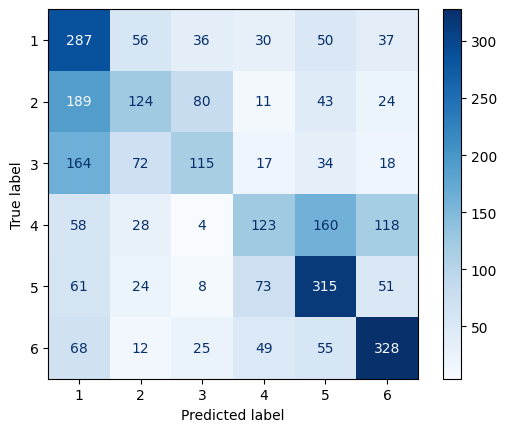

In [10]:
# Treinar a árvore com o melhor ccp_alpha na base de treinamento completa
melhor_arvore = DecisionTreeClassifier(random_state=42, ccp_alpha=melhor_alpha, min_samples_leaf=20)
melhor_arvore.fit(X_train[top_3_features], y_train)

# Fazer predições na base de teste
y_pred_test = melhor_arvore.predict(X_test[top_3_features])

# Calcular a acurácia na base de testes
acuracia_teste = accuracy_score(y_test, y_pred_test)
print(f"Acurácia na base de testes: {acuracia_teste:.4f}")

# Matriz de confusão
matriz_confusao = confusion_matrix(y_test, y_pred_test)
print("\nMatriz de Confusão:")
print(matriz_confusao)

# Visualizar a matriz de confusão
ConfusionMatrixDisplay(confusion_matrix=matriz_confusao, display_labels=melhor_arvore.classes_).plot(cmap="Blues")

### 5. Melhorando a árvore

A melhor forma de se melhorar um algoritmo é colocando nele novas variáveis que agreguem valor. Podemos usar a força-bruta e ir colocando variáveis aleatoriamente - ou colocar todas e deixar rodando por um bom tempo - ou utilizar uma lógica eficiente e fazer uma seleção de variáveis.

- Observe que há classes mais fáceis e mais difíceis de se identificar
- Crie uma variável binária para uma das classes de maior erro
- Fala uma árvore de classificação bem simples para esta variável:
    - utilize ```mean_samples_leaf=20```
    - utilize ```max_depth=4```
    - coloque todas as variáveis
- Observe a importância das variáveis, e selecione as 3 com maior importância
- Rode novamente o algoritmo acima com as 3 novas variáveis e avalie a acurácia

In [11]:
erros_por_classe = matriz_confusao.sum(axis=1) - np.diag(matriz_confusao)
print("Erros por classe:", erros_por_classe)

Erros por classe: [209 347 305 368 217 209]


In [12]:
classe_mais_dificil = np.argmax(erros_por_classe)
print(f"Classe com maior erro: {classe_mais_dificil}")

Classe com maior erro: 3


In [13]:
# Criar uma variável binária para a classe com maior erro
classe_mais_dificil = 3
y_train_bin = (y_train == classe_mais_dificil).astype(int)
y_test_bin = (y_test == classe_mais_dificil).astype(int)

In [14]:
# Treinar uma árvore simples para a classe binária
arvore_simples = DecisionTreeClassifier(max_depth=4, min_samples_leaf=20, random_state=42)
arvore_simples.fit(X_train, y_train_bin)

# Observar a importância das variáveis
importancias = arvore_simples.feature_importances_
variaveis_importantes = X_train.columns[np.argsort(importancias)[-3:][::-1]]  # Top 3
print("Três variáveis mais importantes:", list(variaveis_importantes))

Três variáveis mais importantes: ['tBodyAcc-max()-X', 'tBodyGyro-correlation()-Y,Z', 'fBodyAccMag-mad()']


In [15]:
# Adicionar as novas variáveis às anteriores
variaveis_totais = list(top_3_features) + list(variaveis_importantes)

# Treinar novamente o modelo com as novas variáveis
nova_arvore = DecisionTreeClassifier(random_state=42, ccp_alpha=melhor_alpha, min_samples_leaf=20)
nova_arvore.fit(X_train[variaveis_totais], y_train)

# Avaliar a acurácia com as novas variáveis
y_pred_test_nova = nova_arvore.predict(X_test[variaveis_totais])
acuracia_nova = accuracy_score(y_test, y_pred_test_nova)
print(f"Acurácia com as novas variáveis: {acuracia_nova:.4f}")

Acurácia com as novas variáveis: 0.6169
